## Data Importing and Preprocessing
As first step, data is imported, in line with the typical importing procedure of this project. Then, each imported image is stored as a PIL imaga, as this is the format required to feed them into the model. Next, these images are filtered to leave out the categories Scincidae and Anguidae. The remaining PIL images are split into train, validation and test sets, using the same division percentages and random seeds as in the data preparation to the other models, so to ensure equality of these sets. Eventually, each of these sets and its corresponding label array are merged in a Hugging Faces dictionary and these three dictionaries are then lached into a single datasetDictionary object. 

In [1]:
#import relevant libraries

from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
import numpy as np
import json
import sys
import os

In [2]:
f = open('train.json')
annotations = json.load(f)
image_files = set(os.listdir('NEW'))

image_IDs = {}

for i in annotations['images']: # i['id']
    if i['file_name'].split('/')[-1] in image_files:
        image_IDs[i['id']] = i['file_name'].split('/')[-1]
        
imgID_catIDs = {}

for j in annotations['annotations']:
    if j['image_id'] in image_IDs.keys():
        imgID_catIDs[image_IDs[j['image_id']]] = j['category_id']
        
catIDs_names = {}

for r in annotations['categories']:
    if r['id'] in imgID_catIDs.values():
        catIDs_names[r['id']] = r['family']
        
dict_labels = {}

for val in image_IDs.values():
    dict_labels[val] = catIDs_names[imgID_catIDs[val]]

In [3]:
from PIL import Image
from tqdm import tqdm

PIL_images = []
file_names = []
animals = []

for i,k in tqdm(enumerate(dict_labels.keys())):
    with Image.open('NEW/' + k) as img:
        PIL_images.append(img)
        file_names.append(k)
        animals.append(dict_labels[k])

19648it [00:12, 1527.53it/s]


In [4]:
subset_images = [PIL_images[i] for i in range(len(PIL_images)) if animals[i] != 'Scincidae' and animals[i] != 'Anguidae']
subset_animals = [animals[i] for i in range(len(animals)) if animals[i] != 'Scincidae' and animals[i] != 'Anguidae']

# Generate Train set (70%), validation set (20%), test set (10%) split.
X_train, X_other, y_train, y_other = train_test_split(subset_images, subset_animals, stratify = subset_animals, test_size = 0.3, random_state = 999)
X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, stratify = y_other, test_size = 0.3, random_state = 999)

In [5]:
from datasets import Dataset, DatasetDict

train = Dataset.from_dict({"image": X_train, 'labels': y_train}).class_encode_column('labels')
validation = Dataset.from_dict({'image': X_val, 'labels':y_val}).class_encode_column('labels')
test = Dataset.from_dict({'image':X_test, 'labels':y_test}).class_encode_column('labels')
ds = DatasetDict({'train':train, 'test':test, 'validation':validation})
ds

Casting to class labels:   0%|          | 0/13 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 12188
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 1568
    })
})

## Import, Parametrize and Run the Model
The next step involves the creation of functions to be run into the ViT model, and the parametrization of the instantiation itself.

- To start with, the ViT model is loaded with the weights pretrained on ImageNet. 

- Then, the function transform is created to be employed as input generator for the model. It takes a set of training PIL figures from the training hugging faces dictionary, and it outputs them in a single hugging faces dictionary with their pixel representations in a first arraylike entry and their respective labels in a second. This function is then appended to the DatasetDictionary itself so that it serves as generator sampling from it, and can be invoked upon using the DatasetDictionary. 
- The collate_fn function intakes a set of said elements and returns their pixel representation and their labels separately. This is used in the training phase of the model.
- compute_metrices is invoked in the evaluation phase of training and indicates what metrices are to be calculated and in what manner. 
- In setting the model as ViT from pretrained data, the algorithm is given a way to convert numerical labels into strings and viceversa, respectively in the functions id2label, and label2id. 
- As a last step, the last hyperparameters of the training are set in the training argument function. Here, the training and evaluation approach are set to epochs to increase training speed. 
- Eventually, all these tunings are used in the training step to tailor the model. 

In [6]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [7]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

In [8]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [9]:
from evaluate import load

metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [10]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(    
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    learning_rate=2e-05,
    fp16=True,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
    logging_steps = 1 # so that right after 0 steps it logs the loss
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [16]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [17]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 12188
  Num Epochs = 2
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2438
  Number of trainable parameters = 85810191


Epoch,Training Loss,Validation Loss,Accuracy
1,0.711800,0.808552,0.859056
2,0.283200,0.611441,0.863520


***** Running Evaluation *****
  Num examples = 1568
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-1219
Configuration saved in test-cifar-10/checkpoint-1219/config.json
Model weights saved in test-cifar-10/checkpoint-1219/pytorch_model.bin
Feature extractor saved in test-cifar-10/checkpoint-1219/preprocessor_config.json
/anaconda/envs/py38_default/lib/python3.8/site-packages/transformers/trainer.py:1794: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
***** Running Evaluation *****
  Num examples = 1568
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-2438
Configuration saved in test-cifar-10/checkpoint-2438/config.json
Model weights saved in test-cifar-10/che

***** train metrics *****
  epoch                    =          2.0
  total_flos               = 1759421852GF
  train_loss               =       0.9082
  train_runtime            =   1:05:39.09
  train_samples_per_second =        6.188
  train_steps_per_second   =        0.619


## Model Evaluation
After having trined the model on the training set, and iteratively evaluated in on the validation set, it is possible to assess its performance on unseen data, i.e. the test set. 
- This is performed in the command trainer.evaluate. 
- Next the model is saved, and the code to reload it is commented out.
- DataLoader is another batch generator for the model, in this case it generates a batch of one image a time and one label, they are moved to the GPU, where the model is stored and the predicted label is evaluated and whether it is right is recorded. 
- This information is used to create the confusion matrix by means of a heat map. 

In [18]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 1568
  Batch size = 4


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.8635
  eval_loss               =     0.6114
  eval_runtime            = 0:01:31.36
  eval_samples_per_second =     17.162
  eval_steps_per_second   =      4.291


In [19]:
trainer.save_model('TransformerTL')

Saving model checkpoint to TransformerTL
Configuration saved in TransformerTL/config.json
Model weights saved in TransformerTL/pytorch_model.bin
Feature extractor saved in TransformerTL/preprocessor_config.json


In [ ]:
# model = ViTForImageClassification.from_pretrained(
#     'TransformerTL', 
#     local_files_only=True)
# model.to('cuda')

In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(prepared_ds['train'], collate_fn=collate_fn, batch_size=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

predicted_class_idx = []
real_labels = []
for data in tqdm(train_dataloader):
    inputs, labels = data['pixel_values'], data['labels']
    inputs, labels = inputs.to(device), labels.to(device)
    logits = model(inputs).logits
    predicted_class_idx.append(logits.argmax(-1).item())
    real_labels.append(labels.item())

100%|██████████| 12188/12188 [10:19<00:00, 19.66it/s]


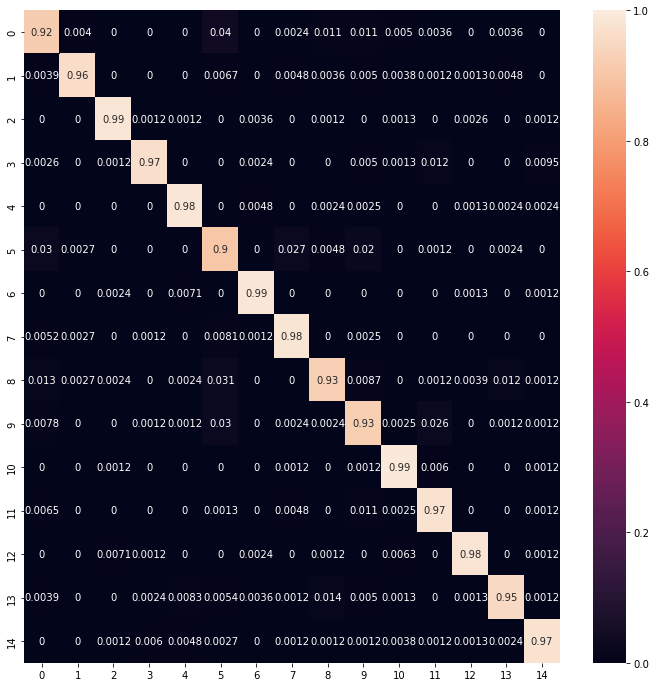

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (12, 12))
cm_VIT = pd.DataFrame(confusion_matrix(real_labels, predicted_class_idx))
heatmap = sns.heatmap(cm_VIT/cm_VIT.sum(axis=1), vmin=0, vmax=1, annot=True)
plt.savefig(f'Transformer Confusion Matrix.png')
plt.show()

In [22]:
plt.savefig(f'Transformer Confusion Matrix.png')

<Figure size 432x288 with 0 Axes>